In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import scipy
import pandas as pd
import torch
from torch import nn
import criscas
from criscas.utilities import create_directory, get_device, report_available_cuda_devices
from criscas.predict_model import *


In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

### Read sample data

In [4]:
seq_df = pd.read_csv(os.path.join(base_dir, 'sample_data', 'abemax_sampledata.csv'), header=0)

In [5]:
seq_df

,ID,seq
0,CTRL_HEKsiteNO18,ACACACACACTTAGAATCTG
1,CTRL_RSF1NO2,ACCCATTAAAGTTGAGGTGA
2,CTRL_EMX1NO2,AGATTTATGCAAACGGGTTG
3,CTRL_FANCFNO3,AGCGGCGGCTGCACAACCAG
4,CTRL_FANCFNO5,AGGCCCGGCGCACGGTGGCG
5,CTRL_TARDBPNO2,CGGGAGTTCTTCTCTCAGTA
6,CTRL_HEKsiteNO1,GAACACAAAGCATAGACTGC
7,CTRL_HEKsiteNO9,GAAGACCAAGGATAGACTGC
8,CTRL_HEKsiteNO2,GAGTATGAGGCATAGACTGC
9,CTRL_EMX1NO1,GAGTCCGAGCAGAAGAAGAA


The models expect sequences (i.e. target sites) to be wrapped in a `pandas.DataFrame` with a header that includes `ID` of the sequence and `seq` columns.
The sequences should be of length 20 (i.e. 20 bases) and represent the protospacer target site.

In [6]:
# create a directory where we dump the predictions of the models
csv_dir = create_directory(os.path.join(base_dir, 'sample_data', 'predictions'))

### Specify device (i.e. CPU or GPU) to run the models on

Specify device to run the model on. The models can run on `GPU` or `CPU`. We can instantiate a device by running `get_device(to_gpu,gpu_index)` function. 

- To run on GPU we pass `to_gpu = True` and specify which card to use if we have multiple cards `gpu_index=int` (i.e. in case we have multiple GPU cards we specify the index counting from 0). 
- If there is no GPU installed, the function will return a `CPU` device.

We can get a detailed information on the GPU cards installed on the compute node by calling `report_available_cuda_devices` function.

In [7]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:Tesla P4
total memory available: 7.43353271484375 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [8]:
# instantiate a device using the only one available :P
device = get_device(True, 0)
device

device(type='cuda', index=0)

### Create a BE-DICT model by sepcifying the target base editor 

We start `BE-DICT` model by calling `BEDICT_CriscasModel(base_editor, device)` where we specify which base editor to use (i.e. `ABEmax`, `BE4`, `ABE8e`, `AID`) and the `device` we create earlier to run on.

In [9]:
base_editor = 'ABEmax'
bedict = BEDICT_CriscasModel(base_editor, device)

We generate predictions by calling `predict_from_dataframe(seq_df)` where we pass the data frame wrapping the target sequences. The function returns two objects:

- `pred_w_attn_runs_df` which is a data frame that contains predictions per target base and the attentions scores across all positions.

- `proc_df` which is a data frame that represents the processed sequence data frame we passed (i.e. `seq_df`)

In [10]:
pred_w_attn_runs_df, proc_df = bedict.predict_from_dataframe(seq_df)

--- processing input data frame ---
--- creating datatensor ---
--- building model ---
--- loading trained model ---
/mnt/orisenbazuru/crispr/ABEmax/train_val/run_0
running prediction for base_editor: ABEmax | run_num: 0
--- loading trained model ---
/mnt/orisenbazuru/crispr/ABEmax/train_val/run_1
running prediction for base_editor: ABEmax | run_num: 1
--- loading trained model ---
/mnt/orisenbazuru/crispr/ABEmax/train_val/run_2
running prediction for base_editor: ABEmax | run_num: 2
--- loading trained model ---
/mnt/orisenbazuru/crispr/ABEmax/train_val/run_3
running prediction for base_editor: ABEmax | run_num: 3
--- loading trained model ---
/mnt/orisenbazuru/crispr/ABEmax/train_val/run_4
running prediction for base_editor: ABEmax | run_num: 4


`pred_w_attn_runs_df` contains predictions from 5 trained models for `ABEmax` base editor (we have 5 runs trained per base editor). For more info, see our [paper](https://www.biorxiv.org/content/10.1101/2020.07.05.186544v1) on biorxiv.

Target positions in the sequence reported in `base_pos` column in `pred_w_attn_runs_df` uses 0-based indexing (i.e. 0-19)

In [11]:
pred_w_attn_runs_df

,id,base_pos,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,Attn5,...,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19,run_id,model_name
0,CTRL_HEKsiteNO18,0,0.999709,0.000291,0.014348,0.048338,0.016288,0.045720,0.019116,0.145056,...,0.015412,0.058490,0.016998,0.016465,0.059028,0.067713,0.067285,0.112856,run_0,ABEmax
1,CTRL_HEKsiteNO18,2,0.969998,0.030002,0.044013,0.051574,0.045433,0.046578,0.047672,0.052783,...,0.045638,0.063682,0.046986,0.046125,0.041857,0.060863,0.043291,0.065565,run_0,ABEmax
2,CTRL_HEKsiteNO18,4,0.054098,0.945902,0.094093,0.022711,0.106497,0.016641,0.100571,0.008621,...,0.091655,0.018518,0.080573,0.097054,0.024016,0.016480,0.024753,0.012796,run_0,ABEmax
3,CTRL_HEKsiteNO18,6,0.900246,0.099754,0.059951,0.058985,0.053788,0.062632,0.034886,0.026394,...,0.075368,0.065085,0.059768,0.045221,0.038758,0.065427,0.031523,0.038408,run_0,ABEmax
4,CTRL_HEKsiteNO18,8,0.942768,0.057232,0.056051,0.052924,0.050032,0.050167,0.042835,0.047317,...,0.057728,0.040145,0.062497,0.056194,0.046561,0.056434,0.047548,0.044195,run_0,ABEmax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,CTRL_NEK1NO2,11,0.932266,0.067734,0.037136,0.028478,0.025359,0.033689,0.023968,0.029764,...,0.035961,0.089764,0.045710,0.100809,0.028398,0.054071,0.105752,0.106517,run_4,ABEmax
601,CTRL_NEK1NO2,13,0.981487,0.018513,0.026479,0.023668,0.022043,0.029213,0.019680,0.022027,...,0.042398,0.105321,0.039242,0.110279,0.024772,0.044570,0.128229,0.111295,run_4,ABEmax
602,CTRL_NEK1NO2,15,0.971135,0.028865,0.027017,0.022021,0.021272,0.039477,0.019656,0.026146,...,0.051267,0.101809,0.036415,0.106422,0.023323,0.044532,0.119506,0.106190,run_4,ABEmax
603,CTRL_NEK1NO2,18,0.999837,0.000163,0.010452,0.007225,0.006333,0.011724,0.005224,0.008501,...,0.017740,0.146858,0.018357,0.162922,0.007708,0.026476,0.179829,0.166394,run_4,ABEmax


In [12]:
proc_df

,index,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20
0,0,1,0,1,0,1,0,1,0,1,...,2,2,0,3,0,0,2,1,2,3
1,1,1,0,0,0,1,0,0,1,1,...,3,2,2,3,0,3,3,2,3,0
2,2,1,0,1,0,0,0,1,0,0,...,0,0,0,1,3,3,3,2,2,3
3,3,1,0,0,0,0,0,0,0,0,...,3,1,0,1,0,0,1,1,0,3
4,4,1,0,0,0,0,0,0,0,0,...,1,0,1,3,3,2,3,3,1,3
5,5,0,0,0,0,1,0,0,0,0,...,2,1,2,1,2,1,0,3,2,0
6,6,0,1,1,0,1,0,1,1,1,...,1,0,2,0,3,0,1,2,3,1
7,7,0,1,1,0,1,0,0,1,1,...,3,0,2,0,3,0,1,2,3,1
8,8,0,1,0,0,1,0,0,1,0,...,1,0,2,0,3,0,1,2,3,1
9,9,0,1,0,0,0,0,0,1,0,...,0,3,0,0,3,0,0,3,0,0


Given that we have 5 predictions per sequence, we can further reduce to one prediction by either `averaging` across all models, or taking the `median` or `max` prediction based on the probability of editing scores. For this we use `select_prediction(pred_w_attn_runs_df, pred_option)` where `pred_w_attn_runs_df` is the data frame containing predictions from 5 models for each sequence. `pred_option` can be assume one of {`mean`, `median`, `max`}.

In [13]:
pred_option = 'mean'
pred_w_attn_df = bedict.select_prediction(pred_w_attn_runs_df, pred_option)

In [14]:
pred_w_attn_df

,id,base_pos,model_name,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,...,Attn10,Attn11,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19
0,CTRL_DOCK3NO2,1,ABEmax,0.999694,0.000306,0.055954,0.083920,0.055398,0.029273,0.066976,...,0.037371,0.050351,0.065975,0.021177,0.045780,0.042680,0.054392,0.024797,0.023750,0.059522
1,CTRL_DOCK3NO2,2,ABEmax,0.989257,0.010743,0.064059,0.057217,0.053120,0.035647,0.044787,...,0.045017,0.050953,0.058711,0.039909,0.050422,0.054270,0.055203,0.040105,0.038902,0.063045
2,CTRL_DOCK3NO2,4,ABEmax,0.027801,0.972199,0.041073,0.035965,0.036837,0.092211,0.057230,...,0.042532,0.042859,0.039368,0.059361,0.045379,0.042745,0.036643,0.054618,0.052010,0.031465
3,CTRL_DOCK3NO2,8,ABEmax,0.963844,0.036156,0.054455,0.058288,0.061597,0.045540,0.049391,...,0.056765,0.042308,0.052514,0.040530,0.044223,0.043556,0.055404,0.044196,0.042889,0.052508
4,CTRL_DOCK3NO2,9,ABEmax,0.964455,0.035545,0.060099,0.051905,0.052061,0.042245,0.046554,...,0.047225,0.047182,0.053338,0.040756,0.045651,0.047976,0.057891,0.042012,0.042788,0.059181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,HEKsite7LV,9,ABEmax,0.953404,0.046596,0.041823,0.054237,0.053839,0.056258,0.055267,...,0.046256,0.060901,0.056168,0.063735,0.057009,0.046230,0.040330,0.038969,0.038606,0.041079
117,HEKsite7LV,11,ABEmax,0.984208,0.015792,0.038248,0.060556,0.055879,0.057153,0.060245,...,0.038827,0.057368,0.060292,0.062552,0.056298,0.045405,0.038160,0.037091,0.037129,0.039475
118,HEKsite7LV,12,ABEmax,0.971138,0.028861,0.038344,0.062133,0.055802,0.055266,0.059578,...,0.042988,0.059114,0.058590,0.058951,0.053746,0.042383,0.038534,0.039799,0.047740,0.043094
119,HEKsite7LV,13,ABEmax,0.993313,0.006688,0.031807,0.060500,0.055020,0.062529,0.073104,...,0.039236,0.063207,0.061411,0.063863,0.058263,0.041553,0.032167,0.029491,0.031877,0.032881


We can dump the prediction results on a specified directory on disk. We will dump the predictions with all 5 runs `pred_w_attn_runs_df` and the one average across runs `pred_w_attn_df`.

Under `sample_data` directory we will have the following tree:

<code>
sample_data
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</code>

In [25]:
pred_w_attn_runs_df.to_csv(os.path.join(csv_dir, f'predictions_allruns.csv'))

In [26]:
pred_w_attn_df.to_csv(os.path.join(csv_dir, f'predictions_predoption_{pred_option}.csv'))

### Generate attention plots

We can generate attention plots for the prediction of each target base in the sequence using `highlight_attn_per_seq` method that takes the following arguments:

- `pred_w_attn_runs_df`: data frame that contains model's predictions (5 runs) for each target base of each sequence (see above).
- `proc_df`: data frame that represents the processed sequence data frame we passed (i.e. seq_df)
- `seqid_pos_map`: dictionary `{seq_id:list of positions}` where `seq_id` is the ID of the target sequence, and list of positions that we want to generate attention plots for. Users can specify a `position from 1 to 20` (i.e. length of protospacer sequence)
- `pred_option`: selection option for aggregating across 5 models' predictions. That is we can average the predictions across 5 runs, or take `max`, `median`, `min` or `None` (i.e. keep all 5 runs) 
- `apply_attnscore_filter`: boolean (`True` or `False`) to further apply filtering on the generated attention scores. This filtering allow to plot only predictions where the associated attention scores have a maximum that is >= 3 times the base attention score value <=> (3 * 1/20)
- `fig_dir`: directory where to dump the generated plots or `None` (to return the plots inline)

highlighting seqid:CTRL_HEKsiteNO1, pos:5
highlighting seqid:CTRL_HEKsiteNO2, pos:5


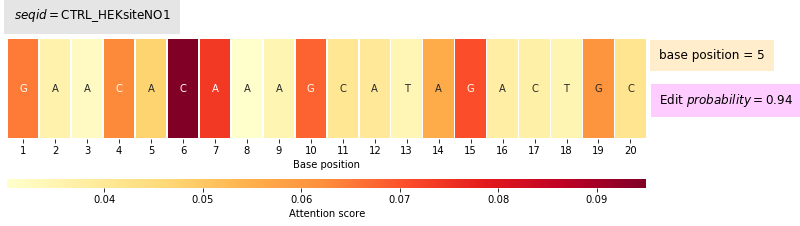

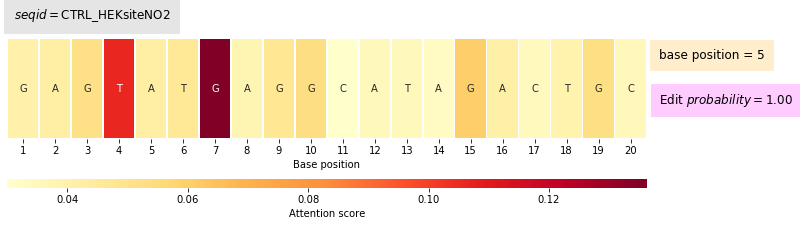

In [23]:
# create a dictionary to specify target sequence and the position I want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=None)

We can save the plots on disk without returning them by specifing `fig_dir`

In [27]:
# create a dictionary to specify target sequence and the position I want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
fig_dir =  create_directory(os.path.join(base_dir, 'sample_data', 'fig_dir'))
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=create_directory(os.path.join(fig_dir, pred_option)))

highlighting seqid:CTRL_HEKsiteNO1, pos:5
highlighting seqid:CTRL_HEKsiteNO2, pos:5


We will generate the following files:

<code>
sample_data
├── abemax_sampledata.csv
├── fig_dir
│   └── mean
│       ├── ABEmax_seqattn_CTRL_HEKsiteNO1_basepos_5_predoption_mean.pdf
│       └── ABEmax_seqattn_CTRL_HEKsiteNO2_basepos_5_predoption_mean.pdf
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</code>

Similarly we can change the other arguments such as `pred_option` `apply_attnscore_filter` and so on to get different filtering options - We leave this as an exercise for the user/reader :D